###Training Models

In [ ]:
#Prepare feature columns
feature_cols = [col for col in df.columns if col != 'fraud']
X = df[feature_cols]
y = df['fraud']

In [ ]:
#Splitting data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [ ]:
#Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_test = X_test_scaled

In [ ]:
#Models to train
models_config = {
    'logistic': LogisticRegression(random_state=42,max_iter=1000,solver='liblinear'),
    'random_forest': RandomForestClassifier(n_estimators=100,random_state=42),
    'xgboost': xgb.XGBClassifier(random_state=42,eval_metric='logloss',use_label_encoder=False,n_jobs=-1),
    'lightgbm': lgb.LGBMClassifier(random_state=42,verbose=-1)
}

In [ ]:
#Training and evaluating models

models ={}
results ={}

for name,model in models_config.items():
  if name == 'logistic':
    model.fit(X_train_scaled,y_train)
    y_pred_proba = model.predict_proba(X_test)[:,1]
  else:
    model.fit(X_train,y_train)
    y_pred_proba = model.predict_proba(X_test)[:,1]

  auc_score = roc_auc_score(y_test, y_pred_proba)
  precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
  pr_auc = auc(recall, precision)


  models[name] = model
  results[name] = {'auc_score': auc_score, 'predictions': y_pred_proba,'pr_auc':pr_auc}

  print(f"{name} AUC: {auc_score: .4f}")


logistic AUC:  0.9801


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


random_forest AUC:  0.8933


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:50:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


xgboost AUC:  0.6682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm AUC:  0.8883


In [ ]:
#Checks class imbalance in training and test sets
print(f"Overall Class Distribution (y):\n{y.value_counts(normalize=True)}")
print(f"Training Set Class Distribution (y_train):\n{y_train.value_counts(normalize=True)}")
print(f"Test Set Class Distribution (y_test):\n{y_test.value_counts(normalize=True)}")

Overall Class Distribution (y):
fraud
0.0    0.912597
1.0    0.087403
Name: proportion, dtype: float64
Training Set Class Distribution (y_train):
fraud
0.0    0.912597
1.0    0.087403
Name: proportion, dtype: float64
Test Set Class Distribution (y_test):
fraud
0.0    0.912597
1.0    0.087403
Name: proportion, dtype: float64


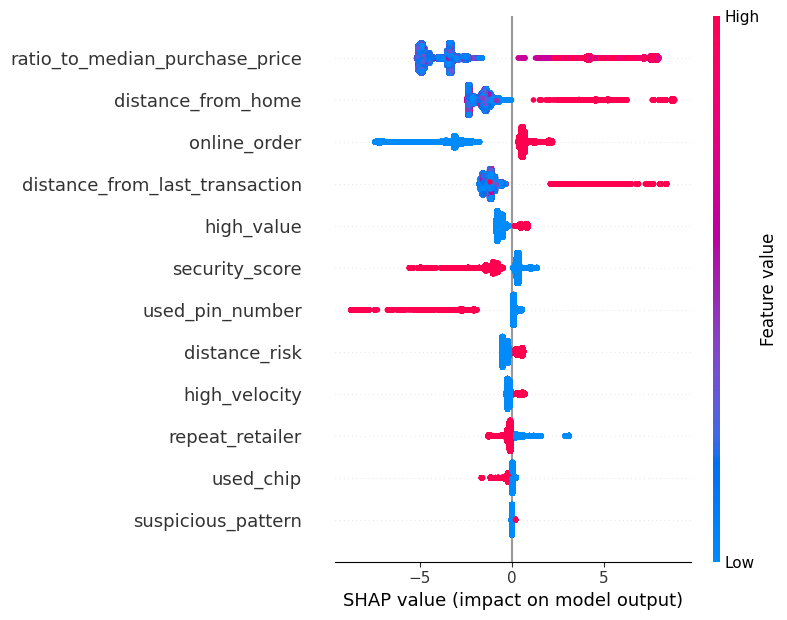

In [ ]:
#SHAP for deeper interpretability
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test) # Overall feature importance
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:]) # Single prediction explanation

###Evaluate Models

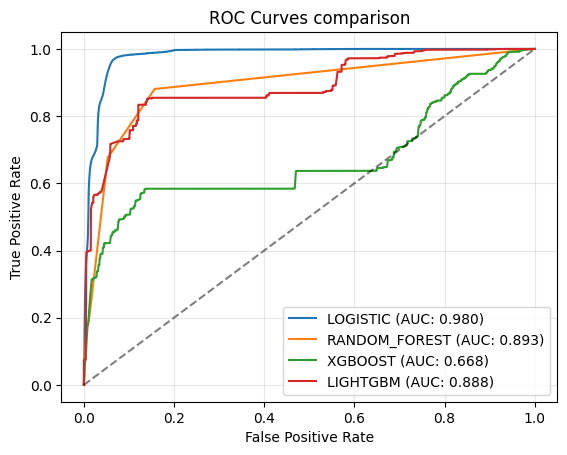

In [ ]:
#Comparing ROC Curves
for name, result in results.items(): # Changed from results.items() to model_results.items()
  fpr,tpr,_ = roc_curve(y_test,result['predictions'])
  plt.plot(fpr, tpr, label=f"{name.upper()} (AUC: {result['auc_score']:.3f})")

plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves comparison')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

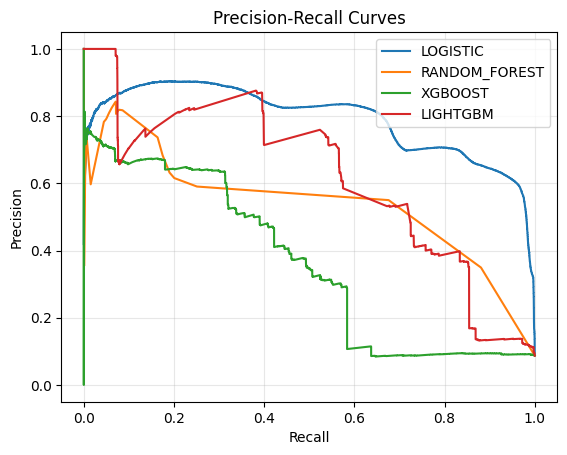

In [ ]:
#Precision-recall curve
for name,result in results.items():
  precision,recall,_ = precision_recall_curve(y_test,result['predictions'])
  plt.plot(recall,precision,label=f"{name.upper()}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curves")
plt.legend(loc='upper right')
plt.grid(True,alpha=0.3)

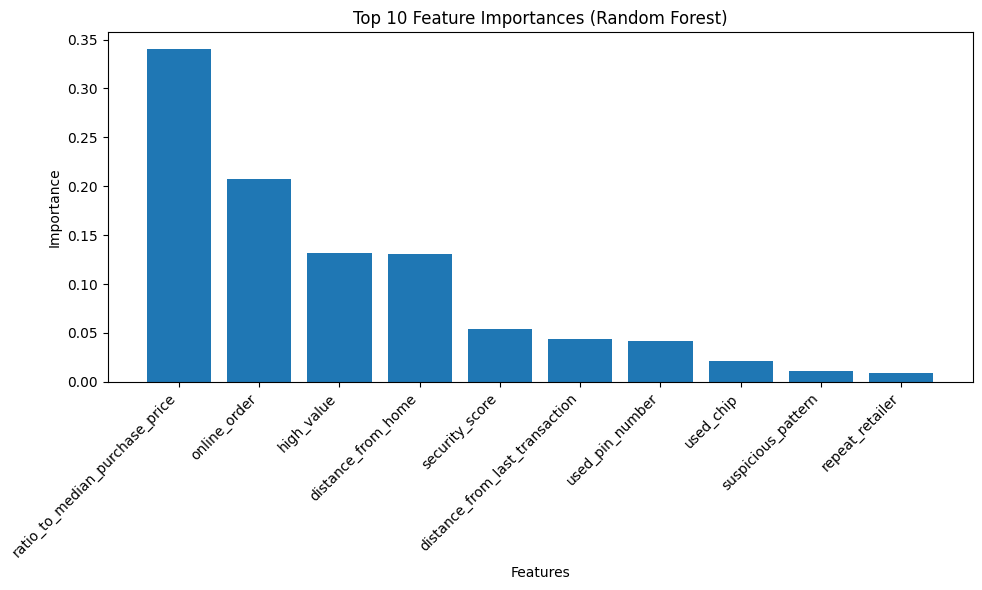

In [ ]:
#Feature importance for random forest
if 'random_forest' in models:
            feature_names = [col for col in df.columns if col != 'fraud']
            importances = models['random_forest'].feature_importances_
            indices = np.argsort(importances)[::-1][:10]

            plt.figure(figsize=(10, 6)) # Added figure size for better visualization
            plt.bar(range(len(indices)), importances[indices])
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.title('Top 10 Feature Importances (Random Forest)')
            plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right') # Corrected xticklabels
            plt.tight_layout() # Adjust layout to prevent labels overlapping
            plt.show()

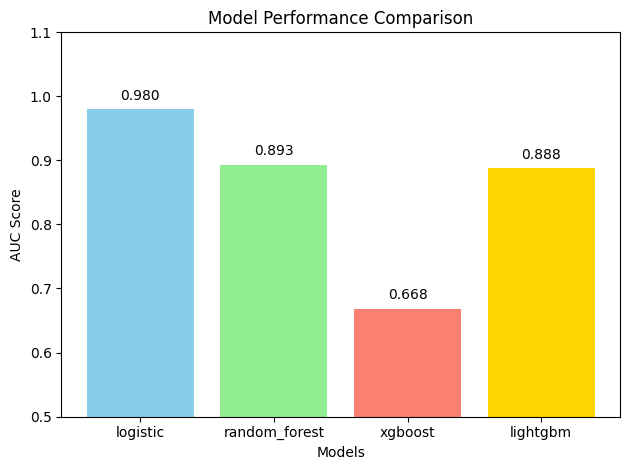

In [ ]:
#Comparing model performances based on AUC score
model_names = list(results.keys())
auc_scores = [results[name]['auc_score'] for name in model_names]

colors = ['skyblue','lightgreen','salmon','gold']
bars = plt.bar(model_names,auc_scores,color=colors[:len(model_names)])
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('Model Performance Comparison')
plt.ylim(0.5,1.1)
for bar, score in zip(bars, auc_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

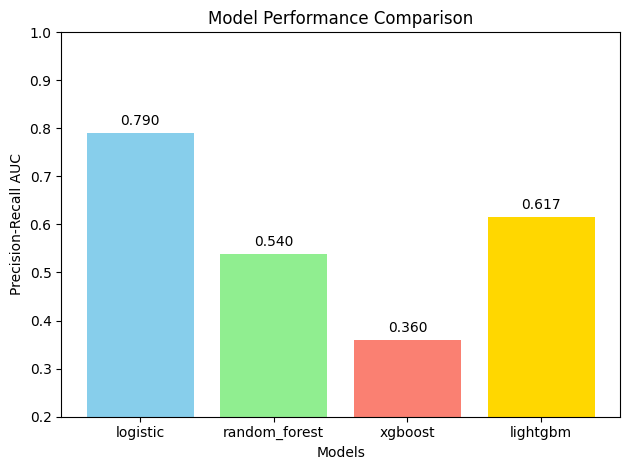

In [ ]:
#Comparing model performances based on PR-AUC
model_names = list(results.keys())
pr_aucs = [results[name]['pr_auc'] for name in model_names]

colors = ['skyblue','lightgreen','salmon','gold']
bars = plt.bar(model_names,pr_aucs,color=colors[:len(model_names)])
plt.xlabel('Models')
plt.ylabel('Precision-Recall AUC')
plt.title('Model Performance Comparison')
plt.ylim(0.2,1.0)
for bar, score in zip(bars, pr_aucs):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
#Choosing the best model
best_model = max(results.keys(),key = lambda x: results[x]['pr_auc'])
print(f"\n Best Model: {best_model} (PR-AUC: {results[best_model]['pr_auc']:.4f})")


 Best Model: logistic (PR-AUC: 0.7901)


Logistic Regression is the best model with an AUC score of 0.9801